In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt


In [2]:
tasks_dataframe = pd.read_csv('/home/michele/Desktop/Data Science/NBD/DC/HW2/Cell_a.csv')

# 1. Dataset Analysis ( aggiungere IMA)

In [3]:
# Removing rows with CPU usage equal to 0 from the dataset
cpu_usage = tasks_dataframe['CPU'] > 0
tasks_dataframe = tasks_dataframe.drop(tasks_dataframe[~cpu_usage].index)
tasks_dataframe

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,603026300,0.041851,0.001169
1,375000669289,0,606413041,0.024968,0.001179
2,375000670586,0,608994453,0.024176,0.001173
3,375000670588,0,608994466,0.019552,0.001163
4,375000670590,0,609042903,0.028044,0.001179
...,...,...,...,...,...
2329127,400465207745,0,2678935469565,0.004677,0.000067
2329128,400465219425,0,2678943690687,0.000343,0.000004
2329129,400465219425,1,2678943690687,0.000557,0.000004
2329130,400465256347,0,2678955330224,0.002459,0.000050


In [4]:
# Converting the Arrival Time column from microseconds to seconds
tasks_dataframe['Arrival_Time'] = tasks_dataframe['Arrival_Time'] / 1000000

In [5]:
tasks_dataframe_reduction = tasks_dataframe.head(300)

# 2. Algorithms

$$ U_{n} = max{(0, U_{n−1} − T_{n})} + X_{n}, n ≥ 1 $$
where:
- U_0 = 0;
- T_n is the inter-arrival time between arrival n − 1 and n;
- X_n is the service time or the n-th arriving task.

In [6]:
import csv
import itertools

class Task:
    def __init__(self, job_id, task_id, arrival_time, cpu_usage, memory_usage):
        self.job_id = job_id
        self.task_id = task_id
        self.arrival_time = arrival_time
        self.cpu_usage = cpu_usage
        self.memory_usage = memory_usage
        self.completion_time = None
        self.service_time = cpu_usage / 0.1

    def __lt__(self, other):
        # Compare tasks based on remaining service time
        return self.service_time < other.service_time
    

# Function to simulate baseline (LWL dispatching and FCFS scheduling)
def calculate_completion_time_baseline(tasks, num_servers):
    servers = [[] for _ in range(N)]  # List of servers, each server can have multiple tasks
    utilization = {}
    unfinished_work = [0] *  N # Unfinished work for each server
    task_completion_times = {}  # Dictionary to store completion time for each task
    service_times = {}
    message_loads = 0
    
    for n in range(len(tasks)):
        
        # LWL DISPATCHING 
        available_servers = [i for i, server_tasks in enumerate(servers) if not server_tasks]  # Find servers with no tasks
        if available_servers:
            server_id = available_servers[0]  # Choose the first available server
        else:
            server_id = unfinished_work.index(min(unfinished_work))  # Find the server with the least unfinished work
        
        # Assign the task to the server
        servers[server_id].append(tasks[n])
        #print(servers)
        
        if server_id in utilization:
            utilization[server_id] += tasks[n].service_time
        else:
            utilization[server_id] = tasks[n].service_time

        # FCFS SCEDULING
        # Calculate completion time for the task
        if len(servers[server_id]) >= 2:
            inter_arrival_time = servers[server_id][-1].arrival_time - servers[server_id][-2].arrival_time
        else:
            inter_arrival_time = 0
            
        #print(inter_arrival_time)
        unfinished_work[server_id] = max(0, unfinished_work[server_id] - inter_arrival_time) + tasks[n].service_time
        #print(unfinished_work[server_id], inter_arrival_time)
        
        #  Update the unfinished work of servers that are not involved
        #for i, server_tasks in enumerate(servers):
        #    if i != server_id:
        #        unfinished_work[i] -= inter_arrival_time
                
        
        # Save service time and task completion time
        if tasks[n].job_id in service_times:
            service_times[tasks[n].job_id] += tasks[n].service_time
        else:
            service_times[tasks[n].job_id] = tasks[n].service_time
            
        task_completion_times[(tasks[n].job_id, tasks[n].task_id, tasks[n].arrival_time, tasks[n].cpu_usage)] = unfinished_work[server_id]

        
        message_loads += 1  # Increase the message load for each task assignment

    mean_message_load = message_loads / len(tasks)  # Compute average message load

        
    return task_completion_times, service_times, utilization, mean_message_load


import heapq

# Function to simulate LWS dispatching and JSN scheduling
def calculate_completion_time_SJN(tasks, num_servers):
    servers = [[] for _ in range(num_servers)]
    unfinished_work = [0] * num_servers
    task_completion_times = {}
    service_times = {}
    message_loads = 0
    utilization = {}

    # Use a priority queue to order tasks by shortest job next (SJN)
    task_queue = []
    for n in range(len(tasks)):
        heapq.heappush(task_queue, (tasks[n].arrival_time, tasks[n].service_time, tasks[n]))

    while task_queue:
        # Get the next task with the shortest remaining service time
        _, _, task = heapq.heappop(task_queue)

        # LWL DISPATCHING 
        available_servers = [i for i, server_tasks in enumerate(servers) if not server_tasks]  # Find servers with no tasks
        if available_servers:
            server_id = available_servers[0]  # Choose the first available server
        else:
            server_id = unfinished_work.index(min(unfinished_work))  # Find the server with the least unfinished work

        # Assign the task to the server
        servers[server_id].append(task)
        
        # Utilization
        if server_id in utilization:
            utilization[server_id] += task.service_time
        else:
            utilization[server_id] = task.service_time

        # Calculate completion time for the task
        if len(servers[server_id]) >= 2:
            inter_arrival_time = servers[server_id][-1].arrival_time - servers[server_id][-2].arrival_time
        else:
            inter_arrival_time = 0
            
        unfinished_work[server_id] = max(0, unfinished_work[server_id] - inter_arrival_time) + task.service_time
        #print(unfinished_work)
        
        # Update the unfinished work of servers that are not involved
        #for i, server_tasks in enumerate(servers):
        #    if i != server_id:
        #        unfinished_work[i] -= inter_arrival_time
                
        # Save service time and task completion time
        if task.job_id in service_times:
            service_times[task.job_id] += task.service_time
        else:
            service_times[task.job_id] = task.service_time
        
        task_completion_times[(task.job_id, task.task_id, task.arrival_time, task.cpu_usage)] = unfinished_work[server_id]
        
        message_loads += 1  # Increase the message load for each task assignment

    mean_message_load = message_loads / len(tasks)  # Compute average message load


    return task_completion_times, service_times, utilization, mean_message_load


## Dispatching Algorithm


LWL (Least Work Left) assigns the processing resource to the process or job with the least amount of remaining work, reducing the waiting time for processing and thus the mean job response time.

In LWL scheduling, the system keeps track of the remaining work or workload of each process or job. When a resource becomes available, LWL selects the process or job with the smallest amount of unfinished work and allocates the resource to it. This approach aims to minimize the time required to complete each job and reduce overall response times.

By prioritizing the processes or jobs with less work left, LWL can effectively distribute resources and ensure that jobs are processed more efficiently. This helps to decrease the waiting time for each job, leading to a reduction in the mean job response time.


## Scheduling Algorithm 

Among the two scheduling policies, FCFS (First-Come, First-Served) and SJN (Shortest Job Next), the SJN policy generally tends to minimize the mean job response time compared to FCFS.

Here's an explanation of the two scheduling policies:

1. FCFS (First-Come, First-Served):

- The FCFS algorithm processes requests based on their arrival order, assigning servers to them sequentially.
- Requests are served one after another, without considering their duration or job complexity.
- If a long-duration request is processed before a shorter one, the overall response time for requests can increase because the shorter requests have to wait longer.

2. SJN (Shortest Job Next):

- The SJN algorithm prioritizes requests based on their expected or estimated duration.
- When a new request arrives, the SJN algorithm selects the request with the shortest duration and processes it first.
- This approach reduces the overall response time as shorter requests are served quickly, thus reducing the wait time for other requests.

In general, the SJN policy is considered more efficient than FCFS in minimizing the mean job response time since it prioritizes shorter requests that require less processing time. This helps reduce the overall waiting time and improve the average response time for requests.



In [7]:
# Read the dataset and create Task objects
tasks = []
for index, row in tasks_dataframe.iterrows():
    job_id = int(row[0])
    task_id = int(row[1])
    arrival_time = float(row[2])
    cpu_usage = float(row[3])
    memory_usage = float(row[4])
    
    task = Task(job_id, task_id, arrival_time, cpu_usage, memory_usage)
    tasks.append(task)

        
# Number of Servers
N = 64

# Simulate baseline (LWL dispatching and FCFS scheduling)
completion_times_baseline, service_times_baseline, utilization_baseline, mean_message_load_baseline = calculate_completion_time_baseline(tasks, N)

# Simulate LWL dispatching and SJN scheduling
completion_times_SJN, service_times_SJN, utilization_SJN, mean_message_load_SJN = calculate_completion_time_SJN(tasks, N)


# 3. Metrics

## 3.1 Job response time R

Time elapsing since the arrival of the first arriving task of a job until all tasks belonging to that job
have been fully served. The mean job response time R is obtained by averaging response times of all jobs

In [8]:
job_response_times_baseline = {}
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times_baseline.items():
    if job_id not in job_response_times_baseline:
        job_response_times_baseline[job_id] = [completion_time]
    else:
        job_response_times_baseline[job_id].append(completion_time)
        
max_times_baseline = {}
for job_id in job_response_times_baseline:
    max_times_baseline[job_id] =  max(job_response_times_baseline[job_id])
    
job_mean_response_time_baseline = np.mean(list(max_times_baseline.values()))
print("Job Mean Response Time R of the baseline:" , job_mean_response_time_baseline)


job_response_times_SJN = {}
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times_SJN.items():
    if job_id not in job_response_times_SJN:
        job_response_times_SJN[job_id] = [completion_time]
    else:
        job_response_times_SJN[job_id].append(completion_time)
        
max_times_SJN = {}
for job_id in job_response_times_SJN:
    max_times_SJN[job_id] = max(job_response_times_SJN[job_id])
    
job_mean_response_time_SJN = np.mean(list(max_times_SJN.values()))
print("Job Mean Response Time R of our algorithms:", job_mean_response_time_SJN)

Job Mean Response Time R of the baseline: 199359.82317775284
Job Mean Response Time R of our algorithms: 189813.82603286018


In [9]:
def indicator(X,t):
    if X<=t:
        return(1)
    else:
        return(0)        

def eCCDF(X, t):
    n=len(X)
    return(1-1/(n-1)*np.sum([indicator(i,t) for i in X]))

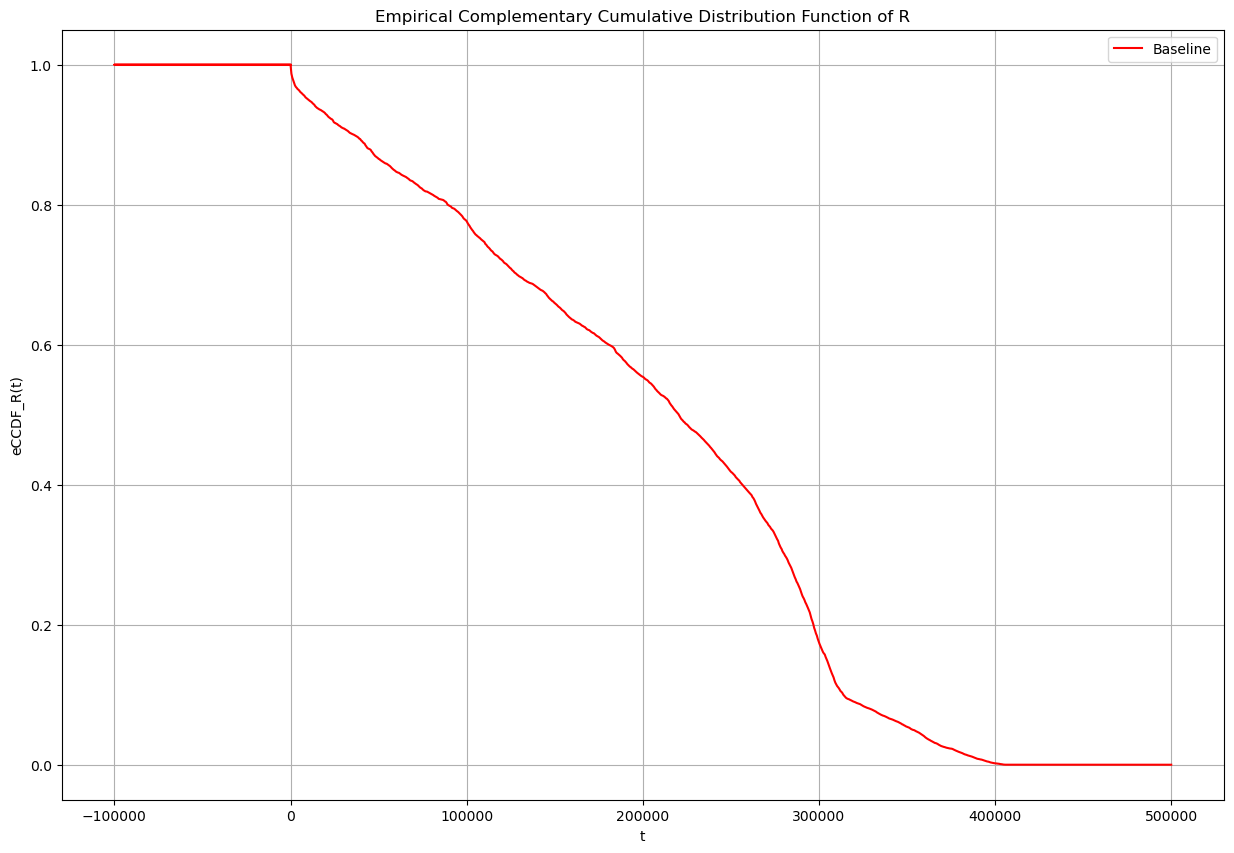

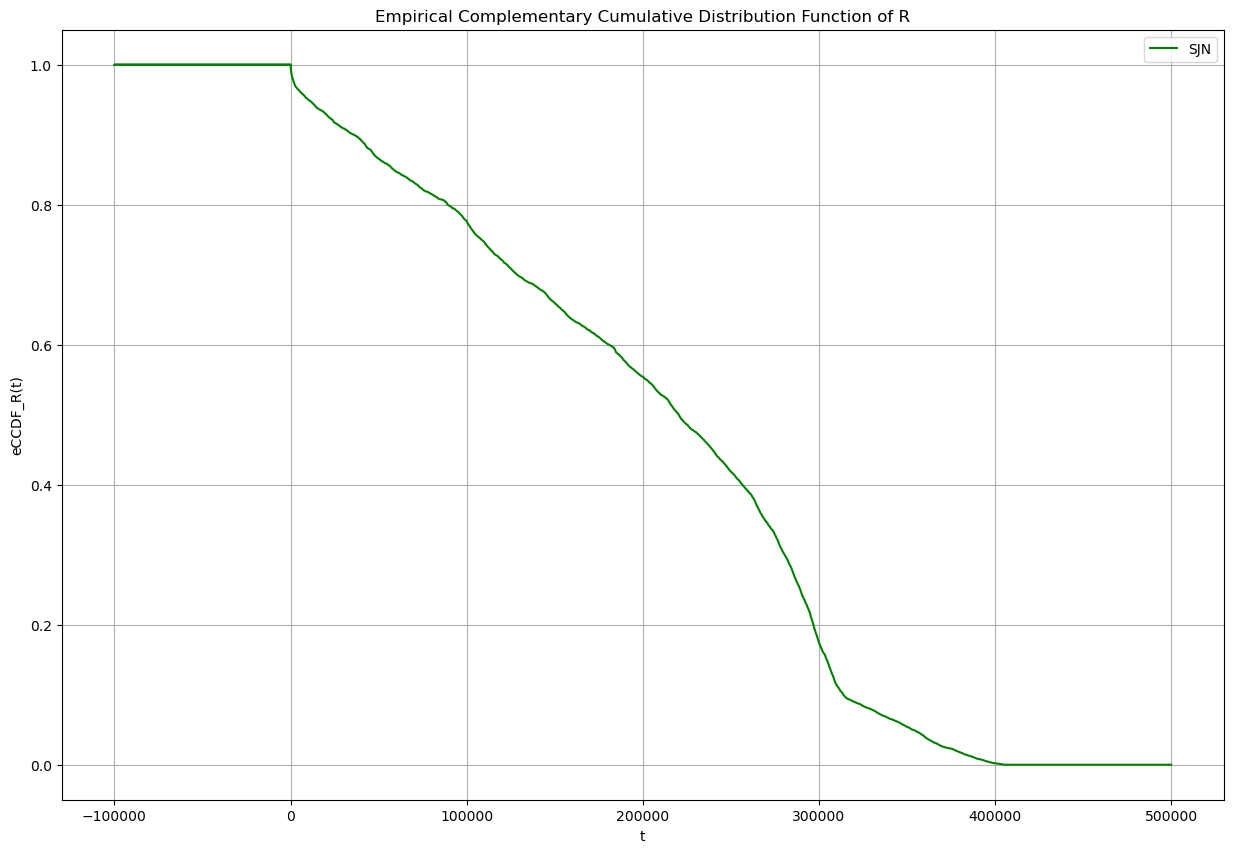

In [10]:
num_cores=multiprocessing.cpu_count() 

times_plot = [-10**i for i in range(1,6)]+list(np.linspace(0, 10**6/2, 1000))
emp_response_SJN = Parallel(n_jobs=num_cores)(delayed(eCCDF)( list(max_times_SJN.values()) , i ) for i in times_plot)
emp_response_baseline = Parallel(n_jobs=num_cores)(delayed(eCCDF)( list(max_times_baseline.values()) , i ) for i in times_plot)

#########################################
# FARLO SIA PER BASELINE CHE PER NOSTRO #
########################################

plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_response_baseline, 'r', label='Baseline')
#plt.scatter(t, emp, marker='*')
plt.grid()
plt.xlabel('t')
plt.ylabel('eCCDF_R(t)')
plt.title('Empirical Complementary Cumulative Distribution Function of R')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_response_baseline, 'g', label='SJN')
#plt.scatter(t, emp, marker='*')
plt.grid()
plt.xlabel('t')
plt.ylabel('eCCDF_R(t)')
plt.title('Empirical Complementary Cumulative Distribution Function of R')
plt.legend()
plt.show()

## 3.2 Job slowdown S

Ratio of response time of the job to the sum of service times of all tasks belonging to the job. The
mean job slowdown S is obtained by averaging slowdown values of all jobs.


In [11]:
job_slowdown_jobs_baseline = []


for job_id, max_time in max_times_baseline.items():
    service_time = service_times_baseline.get(job_id)
    job_slowdown_jobs_baseline.append(max_time/service_time)

job_slowdown_S_baseline = np.mean(job_slowdown_jobs_baseline)
print("Job Slowdown S of baseline: ", job_slowdown_S_baseline)


job_slowdown_jobs_SJN = []
for job_id, max_time in max_times_SJN.items():
    service_time = service_times_SJN.get(job_id)
    job_slowdown_jobs_SJN.append(max_time/service_time)

job_slowdown_S_SJN = np.mean(job_slowdown_jobs_SJN)
print("Job Slowdown S of our algorithm: ", job_slowdown_S_SJN)


Job Slowdown S of baseline:  13611677.801851703
Job Slowdown S of our algorithm:  13082553.900937492


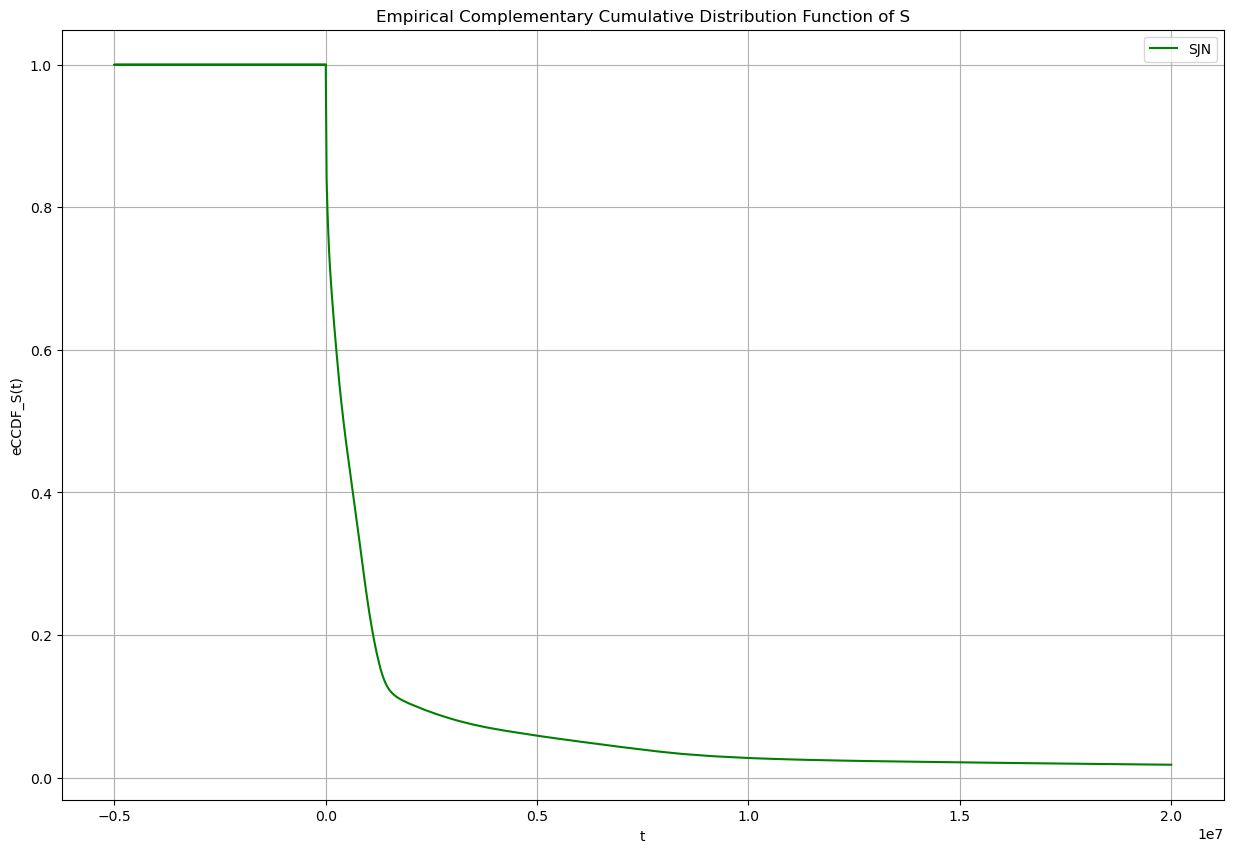

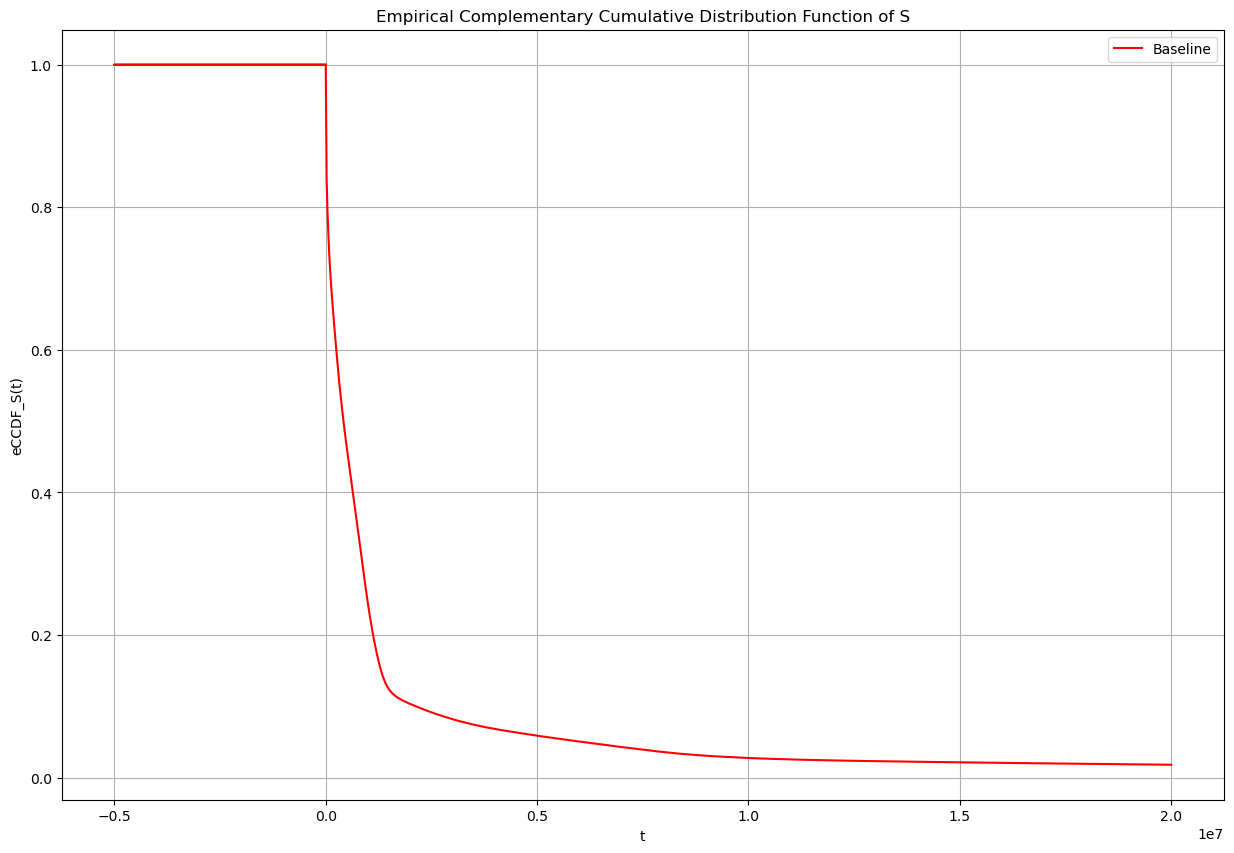

In [12]:
times_plot = [-10**i/2 for i in range(3,8)]+list(np.linspace(0, 10**7*2, 1000))

emp_slowdown_SJN = Parallel(n_jobs=num_cores)(delayed(eCCDF)( job_slowdown_jobs_SJN , i ) for i in times_plot)
emp_slowdown_baseline = Parallel(n_jobs=num_cores)(delayed(eCCDF)( job_slowdown_jobs_baseline , i ) for i in times_plot)

#########################################
# FARLO SIA PER BASELINE CHE PER NOSTRO #
########################################
plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_slowdown_SJN,'g', label='SJN')
#plt.scatter(times_plot, emp_slowdown, marker='*')
plt.grid()
plt.xlabel('t')
plt.ylabel('eCCDF_S(t)')
plt.title('Empirical Complementary Cumulative Distribution Function of S')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_slowdown_SJN,'r', label='Baseline')
#plt.scatter(times_plot, emp_slowdown, marker='*')
plt.grid()
plt.xlabel('t')
plt.ylabel('eCCDF_S(t)')
plt.title('Empirical Complementary Cumulative Distribution Function of S')
plt.legend()
plt.show()

## 3.3 Utilization coefficient of server  k, ρk 

Fraction of time that the server k is busy serving tasks. The overall mean utilization coefficient is ρ = (ρ1 + · · · + ρN)/N.


In [13]:
# DA RIVEDERE, probabilmente non è corretta
mean_utilization_baseline = sum(utilization_baseline.values()) / len(utilization_baseline.keys())
print("Mean Utilization of the baselien:", mean_utilization_baseline)

print(" ")

mean_utilization_SJN = sum(utilization_SJN.values()) / len(utilization_SJN.keys())
#print(utilizations_SJN)
print("Mean Utilization of our algorithms:", mean_utilization_SJN)

Mean Utilization of the baselien: 1442091.19797647
 
Mean Utilization of our algorithms: 1442091.19797647


In [14]:
Ro_baseline=pd.DataFrame([utilization_baseline.values()], columns= utilization_baseline.keys())
Ro_baseline

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.688625e+06,2.001662e+06,823944.745426,1.304587e+06,1.206408e+06,1.252200e+06,884381.655111,1.238222e+06,1.276929e+06,1.651830e+06,...,2.494858e+06,796812.376328,1.265300e+06,1.511115e+06,1.277836e+06,1.565436e+06,2.184206e+06,1.787848e+06,1.193235e+06,2.169797e+06


In [15]:
Ro_SJN=pd.DataFrame([utilization_SJN.values()], columns=utilization_SJN.keys())
Ro_SJN

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.128001e+06,2.037342e+06,1.282184e+06,1.689658e+06,1.511265e+06,969827.231731,1.547931e+06,1.644576e+06,2.063719e+06,1.702563e+06,...,1.685582e+06,1.982771e+06,2.113656e+06,835442.502575,914549.682178,1.563085e+06,848868.938713,1.356810e+06,865351.876545,1.354228e+06


In [16]:
##################################################################################################
# VEDETE QUALE VI PIACE DI PIU' COME "TABELLA" SE INSIEME, IN VERTICALE, ORIZZONTALE..  BOH      #
# NON ENTRERA' MAI NEL PDF MA NON SO CHE TABELLA VORREBBE VISTO CHE SONO 64 VALORI E SONO TANTI  #
##################################################################################################

Ro_k=pd.DataFrame.from_dict({'Server Number': list(range(64)), 'Ro Baseline': utilization_baseline.values(),'Ro SJN': utilization_SJN.values()})
Ro_k

,Server Number,Ro Baseline,Ro SJN
0,0,1.688625e+06,1.128001e+06
1,1,2.001662e+06,2.037342e+06
2,2,8.239447e+05,1.282184e+06
3,3,1.304587e+06,1.689658e+06
4,4,1.206408e+06,1.511265e+06
...,...,...,...
59,59,1.565436e+06,1.563085e+06
60,60,2.184206e+06,8.488689e+05
61,61,1.787848e+06,1.356810e+06
62,62,1.193235e+06,8.653519e+05


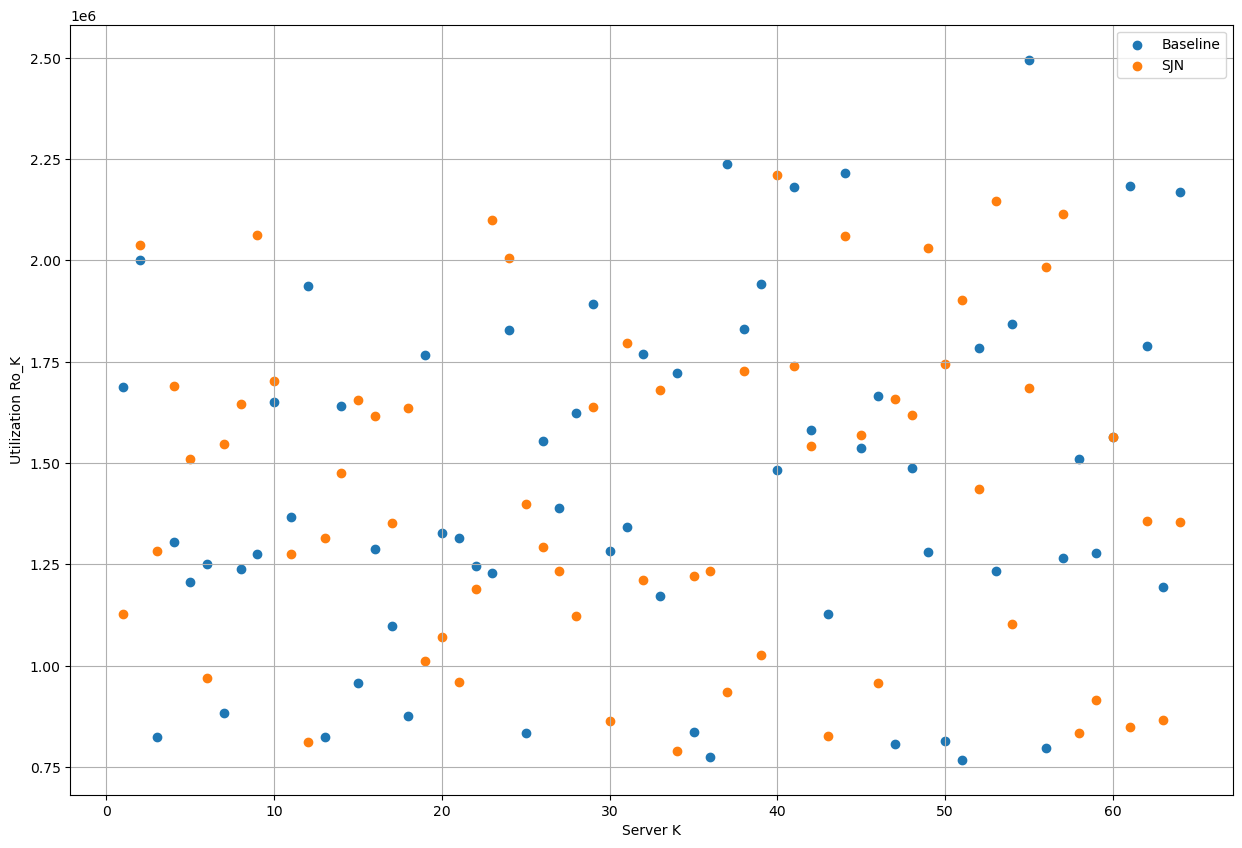

In [17]:
########################################################
# QUESTO PLOT E' INUTILE, VEDETE SE VOLETE AGGIUNGERLO #
########################################################



Servers_plot=[i for i in range(1,65)]
Ro_k_baseline=utilization_baseline.values()
Ro_k_SJN=utilization_SJN.values()
plt.figure(figsize=(15, 10))
plt.scatter(Servers_plot, Ro_k_baseline, label='Baseline')
plt.scatter(Servers_plot, Ro_k_SJN, label='SJN' )
plt.xlabel('Server K')
plt.ylabel('Utilization Ro_K')
plt.legend(fontsize = 10)
plt.grid()
plt.show()


Changing from a First-Come, First-Served (FCFS) scheduling algorithm to a Shortest Job Next (SJN) algorithm can lead to a variation in server utilization. The SJF algorithm prioritizes the execution of shorter tasks, which can reduce the idle time of the server and potentially increase the overall server utilization.

## 3.4 Messaging load L

Number of messages exchanged between the dispatcher and servers for a given task dispatching. The
mean message load L is obtained by averaging message load values of all tasks.

In [18]:
print("Mean Message Load of the baselien:", mean_message_load_baseline)
print()
print("Mean Message Load of our algorithms:", mean_message_load_SJN)

Mean Message Load of the baselien: 1.0

Mean Message Load of our algorithms: 1.0


# 4. Example

In [19]:
######ESEMPIO######
tasks_2 = [Task(0, 0, 0, 1.5, 0.3),
         Task(0, 1, 0, 2.2, 0.5),
         Task(0, 2, 0, 2.5, 0.5), 
         Task(1, 1, 3, 0.8, 0.7),
         Task(2, 0, 4, 3.0, 0.9)]
            
    
µ = 0.1
N = 2
completion_times, service_times, mean_message_load = calculate_completion_time_baseline(tasks_2, N)

# Print completion time for each task
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times.items():
    print(f"Job ID: {job_id}, Task ID: {task_id}, Arrival Time : {arrival_time}, CPU : {cpu_usage},  Completion Time: {completion_time}")

ValueError: too many values to unpack (expected 3)